In [1]:
# Code based on https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

import numpy as np
from numpy.random import randint
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Input, Concatenate, LeakyReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [2]:
# generate circles - rectangles pairs
import cv2
import random
n = 500
size = 256
trainImgs = []
trainMaps = []

for i in range(n):
    sampleA = np.zeros((size,size,3))
    sampleB = np.zeros((size,size,3))
    for _ in range(5):
        x0 = random.randrange(5,size-5)
        y0 = random.randrange(5,size-5)
        r0 = random.randrange(5,25)
        sampleA = cv2.circle(sampleA,(x0,y0),r0,(150,50,255),-1)
        sampleB = cv2.rectangle(sampleB,(x0,y0),(x0+r0,y0+r0),(50,255,100),-1)
    trainImgs.append(sampleA)
    trainMaps.append(sampleB)
trainImgs = np.array(trainImgs)
trainMaps = np.array(trainMaps)
trainImgs = trainImgs/255.0
trainMaps = trainMaps/255.0

In [3]:
trainImgs.shape

(500, 256, 256, 3)

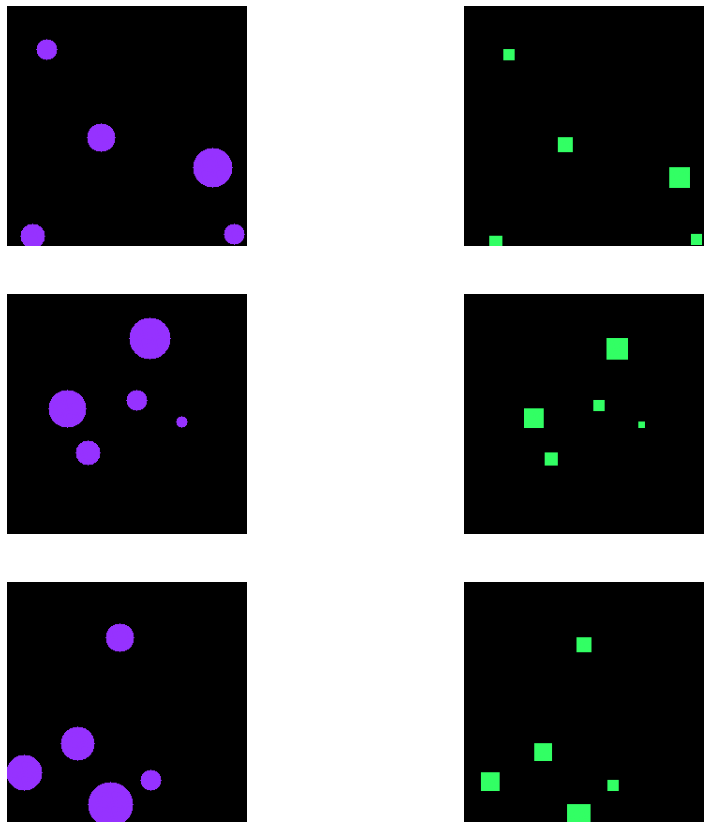

In [4]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(15, 15))
n = 3
x = 1
for i in range(n):
    ax = plt.subplot(3, 2, x)
    x = x + 1
    plt.imshow(trainImgs[i])
    plt.axis("off")
    ax = plt.subplot(3, 2, x)
    x = x + 1
    plt.imshow(trainMaps[i])
    plt.axis("off")
plt.show()

In [5]:
# recalcuate to (-1,1)
trainImgs = (trainImgs - 0.5) / 0.5
trainMaps = (trainMaps - 0.5) / 0.5

## Discriminator model

In [6]:
from tensorflow.keras.initializers import RandomNormal
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input A
    in_src_image = Input(shape=image_shape)
    # target image input B
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model
d_model = define_discriminator((256,256,3))
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

## Generator model

In [7]:
# define an encoder block
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model
    
g_model = define_generator()
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model
gan_model = define_gan(g_model, d_model, (256,256,3))

In [9]:
# select a batch of random samples, returns images and target
def generate_real_samples(samples):
    ix = randint(0, trainImgs.shape[0], samples)
    X1, X2 = trainImgs[ix], trainMaps[ix]
    return X1, X2

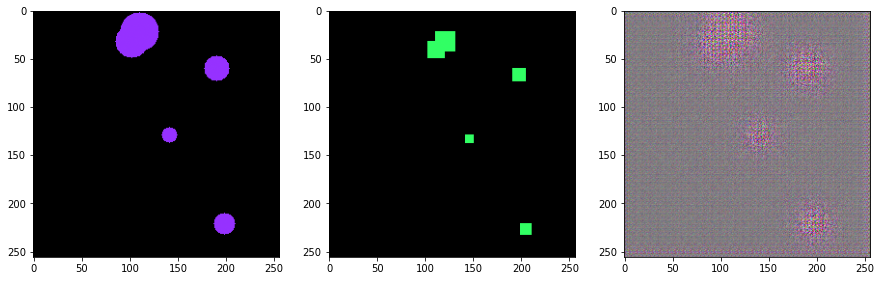

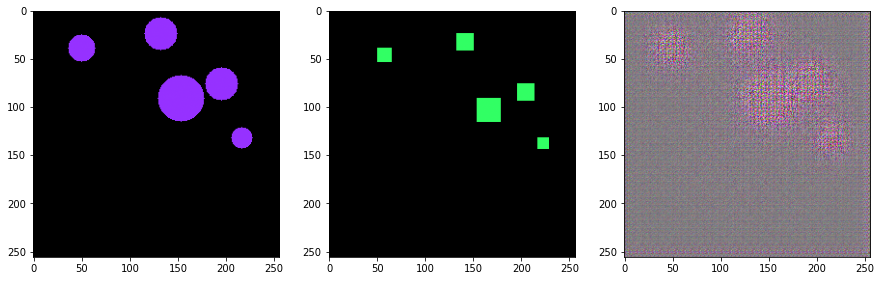

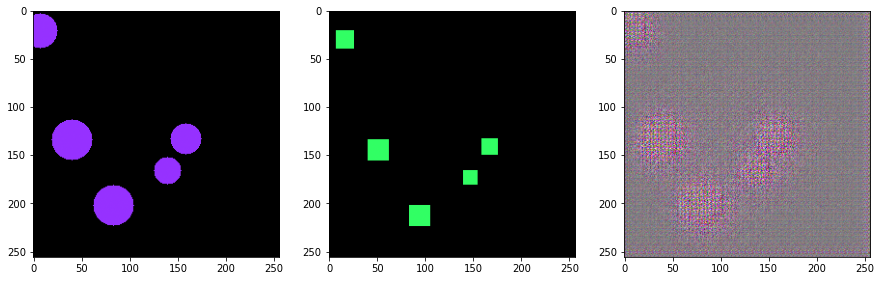

In [10]:
def show_results(step, g_model, samples=3):
    # select a sample of input images
    realA, realB = generate_real_samples(samples)
    fakeB = g_model.predict(realA[:samples])
    realA = (realA+1.0)/2.0
    realB = (realB+1)/2
    fakeB = (fakeB+1)/2
    
    for i in range(samples):
        plt.figure(figsize=(15, 15))
        ax = plt.subplot(1, 3, 1)
        plt.imshow(realA[i])
        ax = plt.subplot(1, 3, 2)
        plt.imshow(realB[i])
        ax = plt.subplot(1, 3, 3)
        plt.imshow(fakeB[i])
    plt.show()
show_results(0,g_model,3)

In [11]:
# train pix2pix model
def train(d_model, g_model, gan_model, epochs=100, batch=1):
    # determine the output square shape of the discriminator
    patch = d_model.output_shape[1]
    steps = int(len(trainImgs) / batch)
    all_ones = np.ones((batch, patch, patch, 1))
    all_zeros = np.zeros((batch, patch, patch, 1))
    # manually enumerate epochs
    for epoch in range(epochs):
        show_results(epoch, g_model, samples=1)
        print(f"Calculating next {steps} batches of size {batch}")
        for i in range(steps):
            # select a batch of real samples
            realA, realB = generate_real_samples(batch)
            # generate a batch of fake samples
            fakeB = g_model.predict(realA)
            # update discriminator for real samples
            d_loss_real = d_model.train_on_batch([realA, realB], all_ones )
            # update discriminator for generated samples
            d_loss_fake = d_model.train_on_batch([realA, fakeB], all_zeros)
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(realA, [all_ones, realB])
            #print(f"Iteration {i}/{n_steps} g_loss={g_loss:.3f}, d_loss_real={d_loss_real:.3f}, d_loss_fake={d_loss_fake:.3f}")
            print(".",end='')
        print()    
        print(f"Epoch {epoch} g_loss={g_loss:.3f}, d_loss_real={d_loss_real:.3f}, d_loss_fake={d_loss_fake:.3f}")


In [12]:
# load image data
image_shape = (256,256,3) #dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

ResourceExhaustedError: OOM when allocating tensor with shape[4,4,512,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

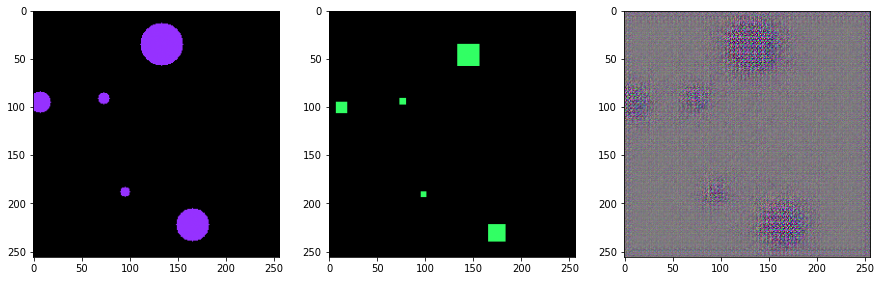

Calculating next 62 batches of size 8
..............................................................
Epoch 0 g_loss=8.950, d_loss_real=0.051, d_loss_fake=0.040


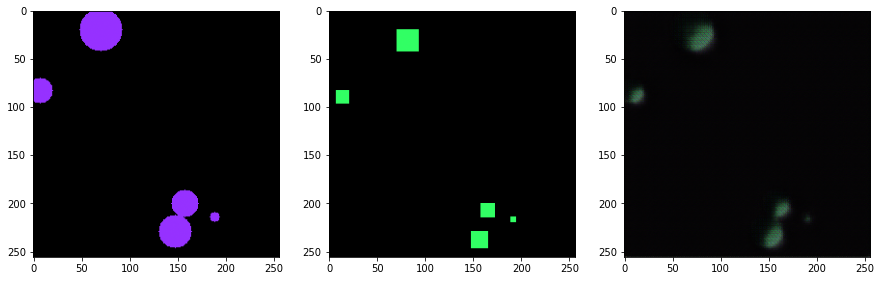

Calculating next 62 batches of size 8
..............................................................
Epoch 1 g_loss=3.342, d_loss_real=0.345, d_loss_fake=0.416


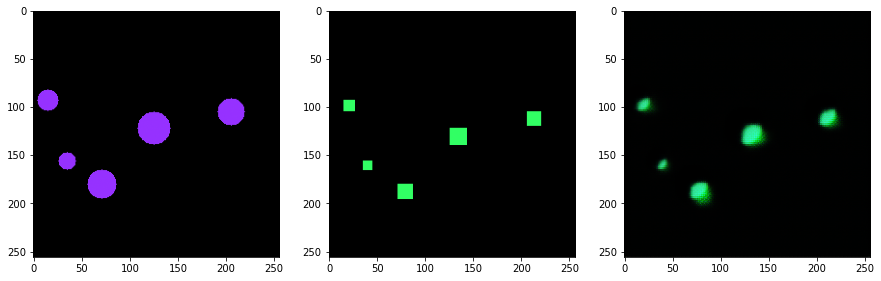

Calculating next 62 batches of size 8
..............................................................
Epoch 2 g_loss=2.204, d_loss_real=0.342, d_loss_fake=0.395


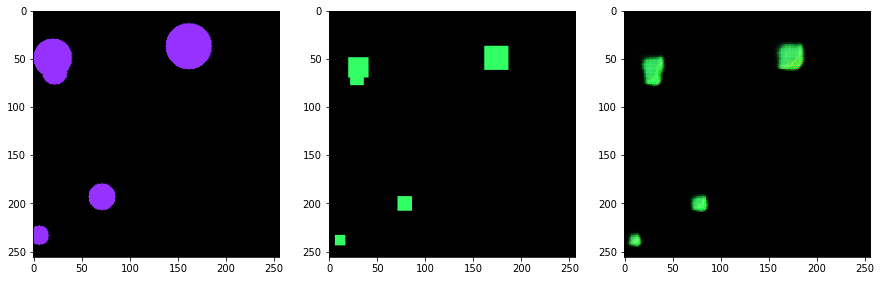

Calculating next 62 batches of size 8
..............................................................
Epoch 3 g_loss=2.330, d_loss_real=0.272, d_loss_fake=0.380


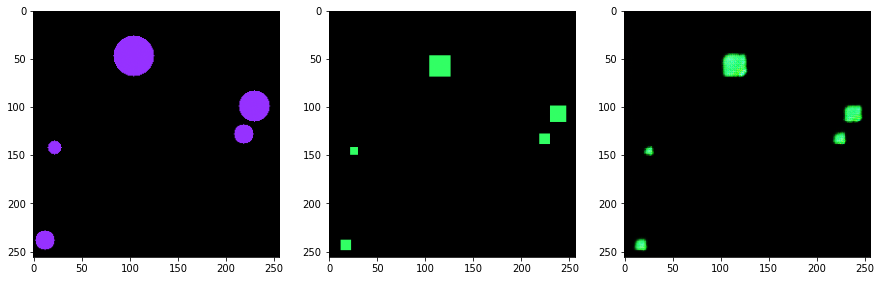

Calculating next 62 batches of size 8
..............................................................
Epoch 4 g_loss=1.990, d_loss_real=0.376, d_loss_fake=0.352


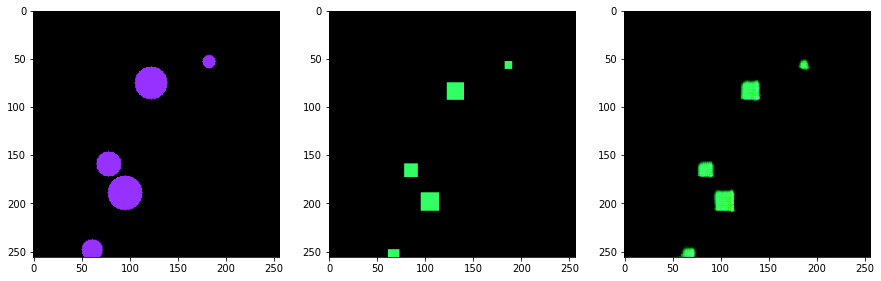

Calculating next 62 batches of size 8
..............................................................
Epoch 5 g_loss=1.612, d_loss_real=0.408, d_loss_fake=0.385


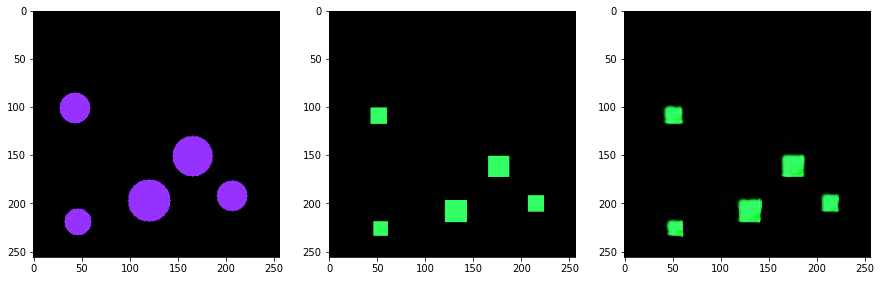

Calculating next 62 batches of size 8
..............................................................
Epoch 6 g_loss=2.039, d_loss_real=0.175, d_loss_fake=0.311


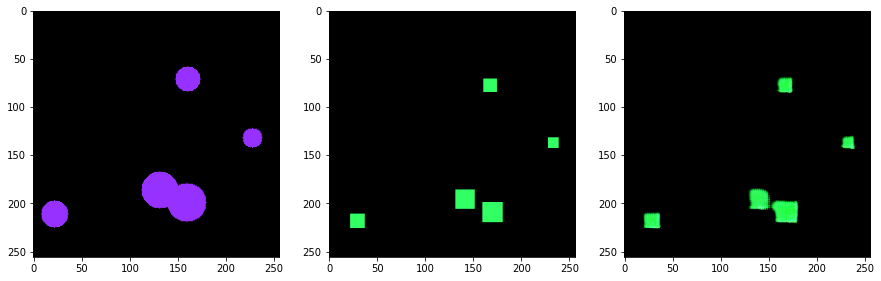

Calculating next 62 batches of size 8
..............................................................
Epoch 7 g_loss=1.098, d_loss_real=0.368, d_loss_fake=0.374


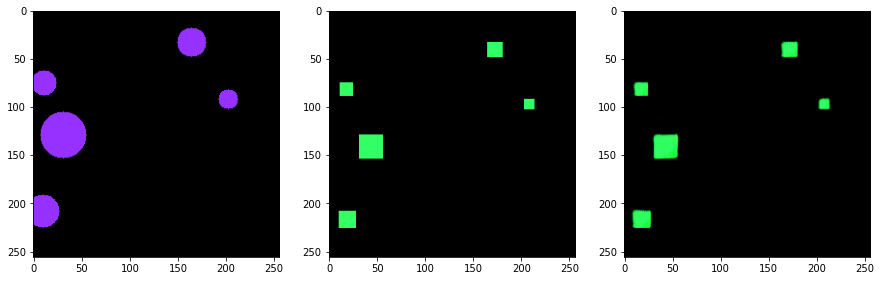

Calculating next 62 batches of size 8
..............................................................
Epoch 8 g_loss=1.201, d_loss_real=0.382, d_loss_fake=0.338


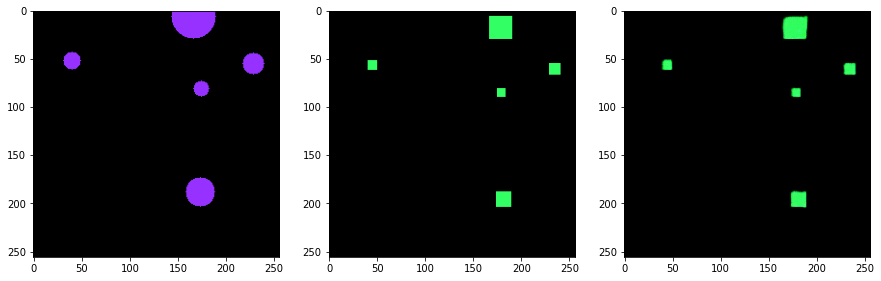

Calculating next 62 batches of size 8
..............................................................
Epoch 9 g_loss=1.079, d_loss_real=0.361, d_loss_fake=0.368


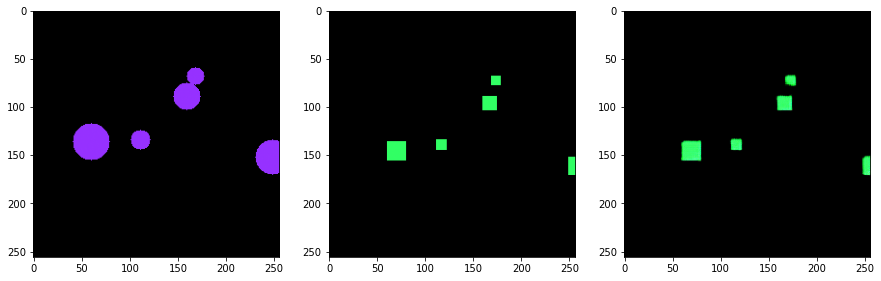

Calculating next 62 batches of size 8
..............................................................
Epoch 10 g_loss=1.116, d_loss_real=0.382, d_loss_fake=0.340


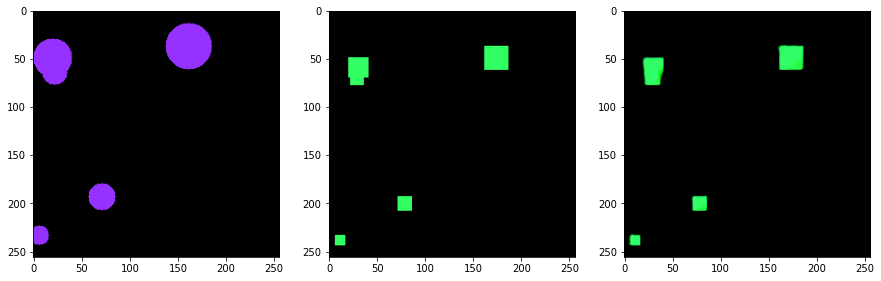

Calculating next 62 batches of size 8
..............................................................
Epoch 11 g_loss=2.375, d_loss_real=1.031, d_loss_fake=0.288


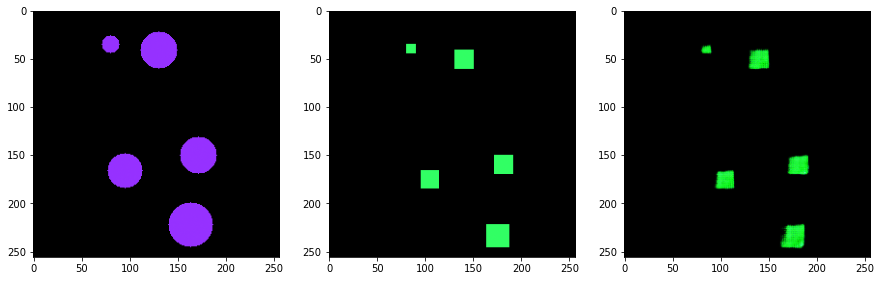

Calculating next 62 batches of size 8
..............................................................
Epoch 12 g_loss=3.074, d_loss_real=0.065, d_loss_fake=0.080


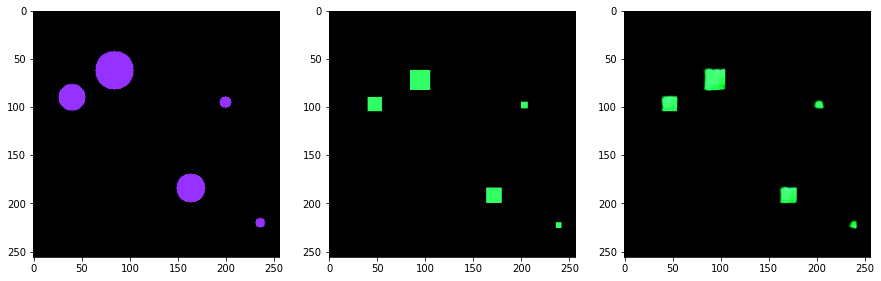

Calculating next 62 batches of size 8
..............................................................
Epoch 13 g_loss=1.527, d_loss_real=0.308, d_loss_fake=0.393


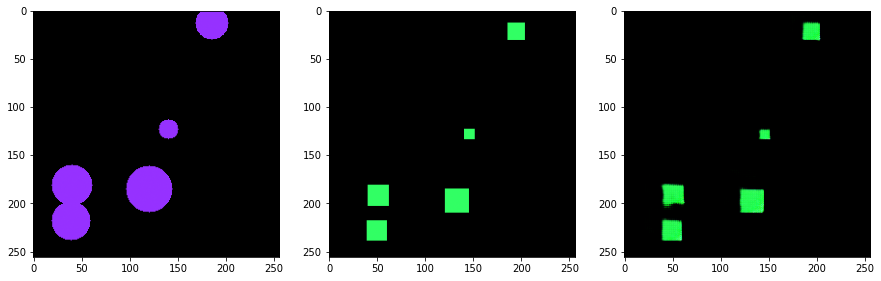

Calculating next 62 batches of size 8
.......

KeyboardInterrupt: 

In [13]:
# train model
train(d_model, g_model, gan_model, 100, 8)

In [ ]:
show_results(0,g_model,10)